# Embedding

## Comparison between Ng Laplacian and ShiMalik Laplacian
Given a weight matrix $W$, the `ShiMalikLaplacian` embedding method obtains $V_1$, the $k$ eigenvectors corresponding to the $k$ smallest eigenvalues different from 0 of the matrix  $NL = D^{-\frac{1}{2}}(D-W)D^{-\frac{1}{2}}$. Then computes $X_1 = D^{\frac{1}{2}} V_1$ to obtain the solution of the generalized eigenvalue problem $(D-W)X_1 = \lambda D X_1$.

The `NgLaplacian` embedding method computes the $k$ eigenvectors corresponding to the $k$ largest eigenvalues of $L  = D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$.

The eigenvectors obtained with both metods should be the same. The eigenvalues are shifted: the eigenvectors corresponding to the eigenvalue $0$ of $NL$ are the eigenvectors corresponding to the eigenvalue $1$ of $L$.

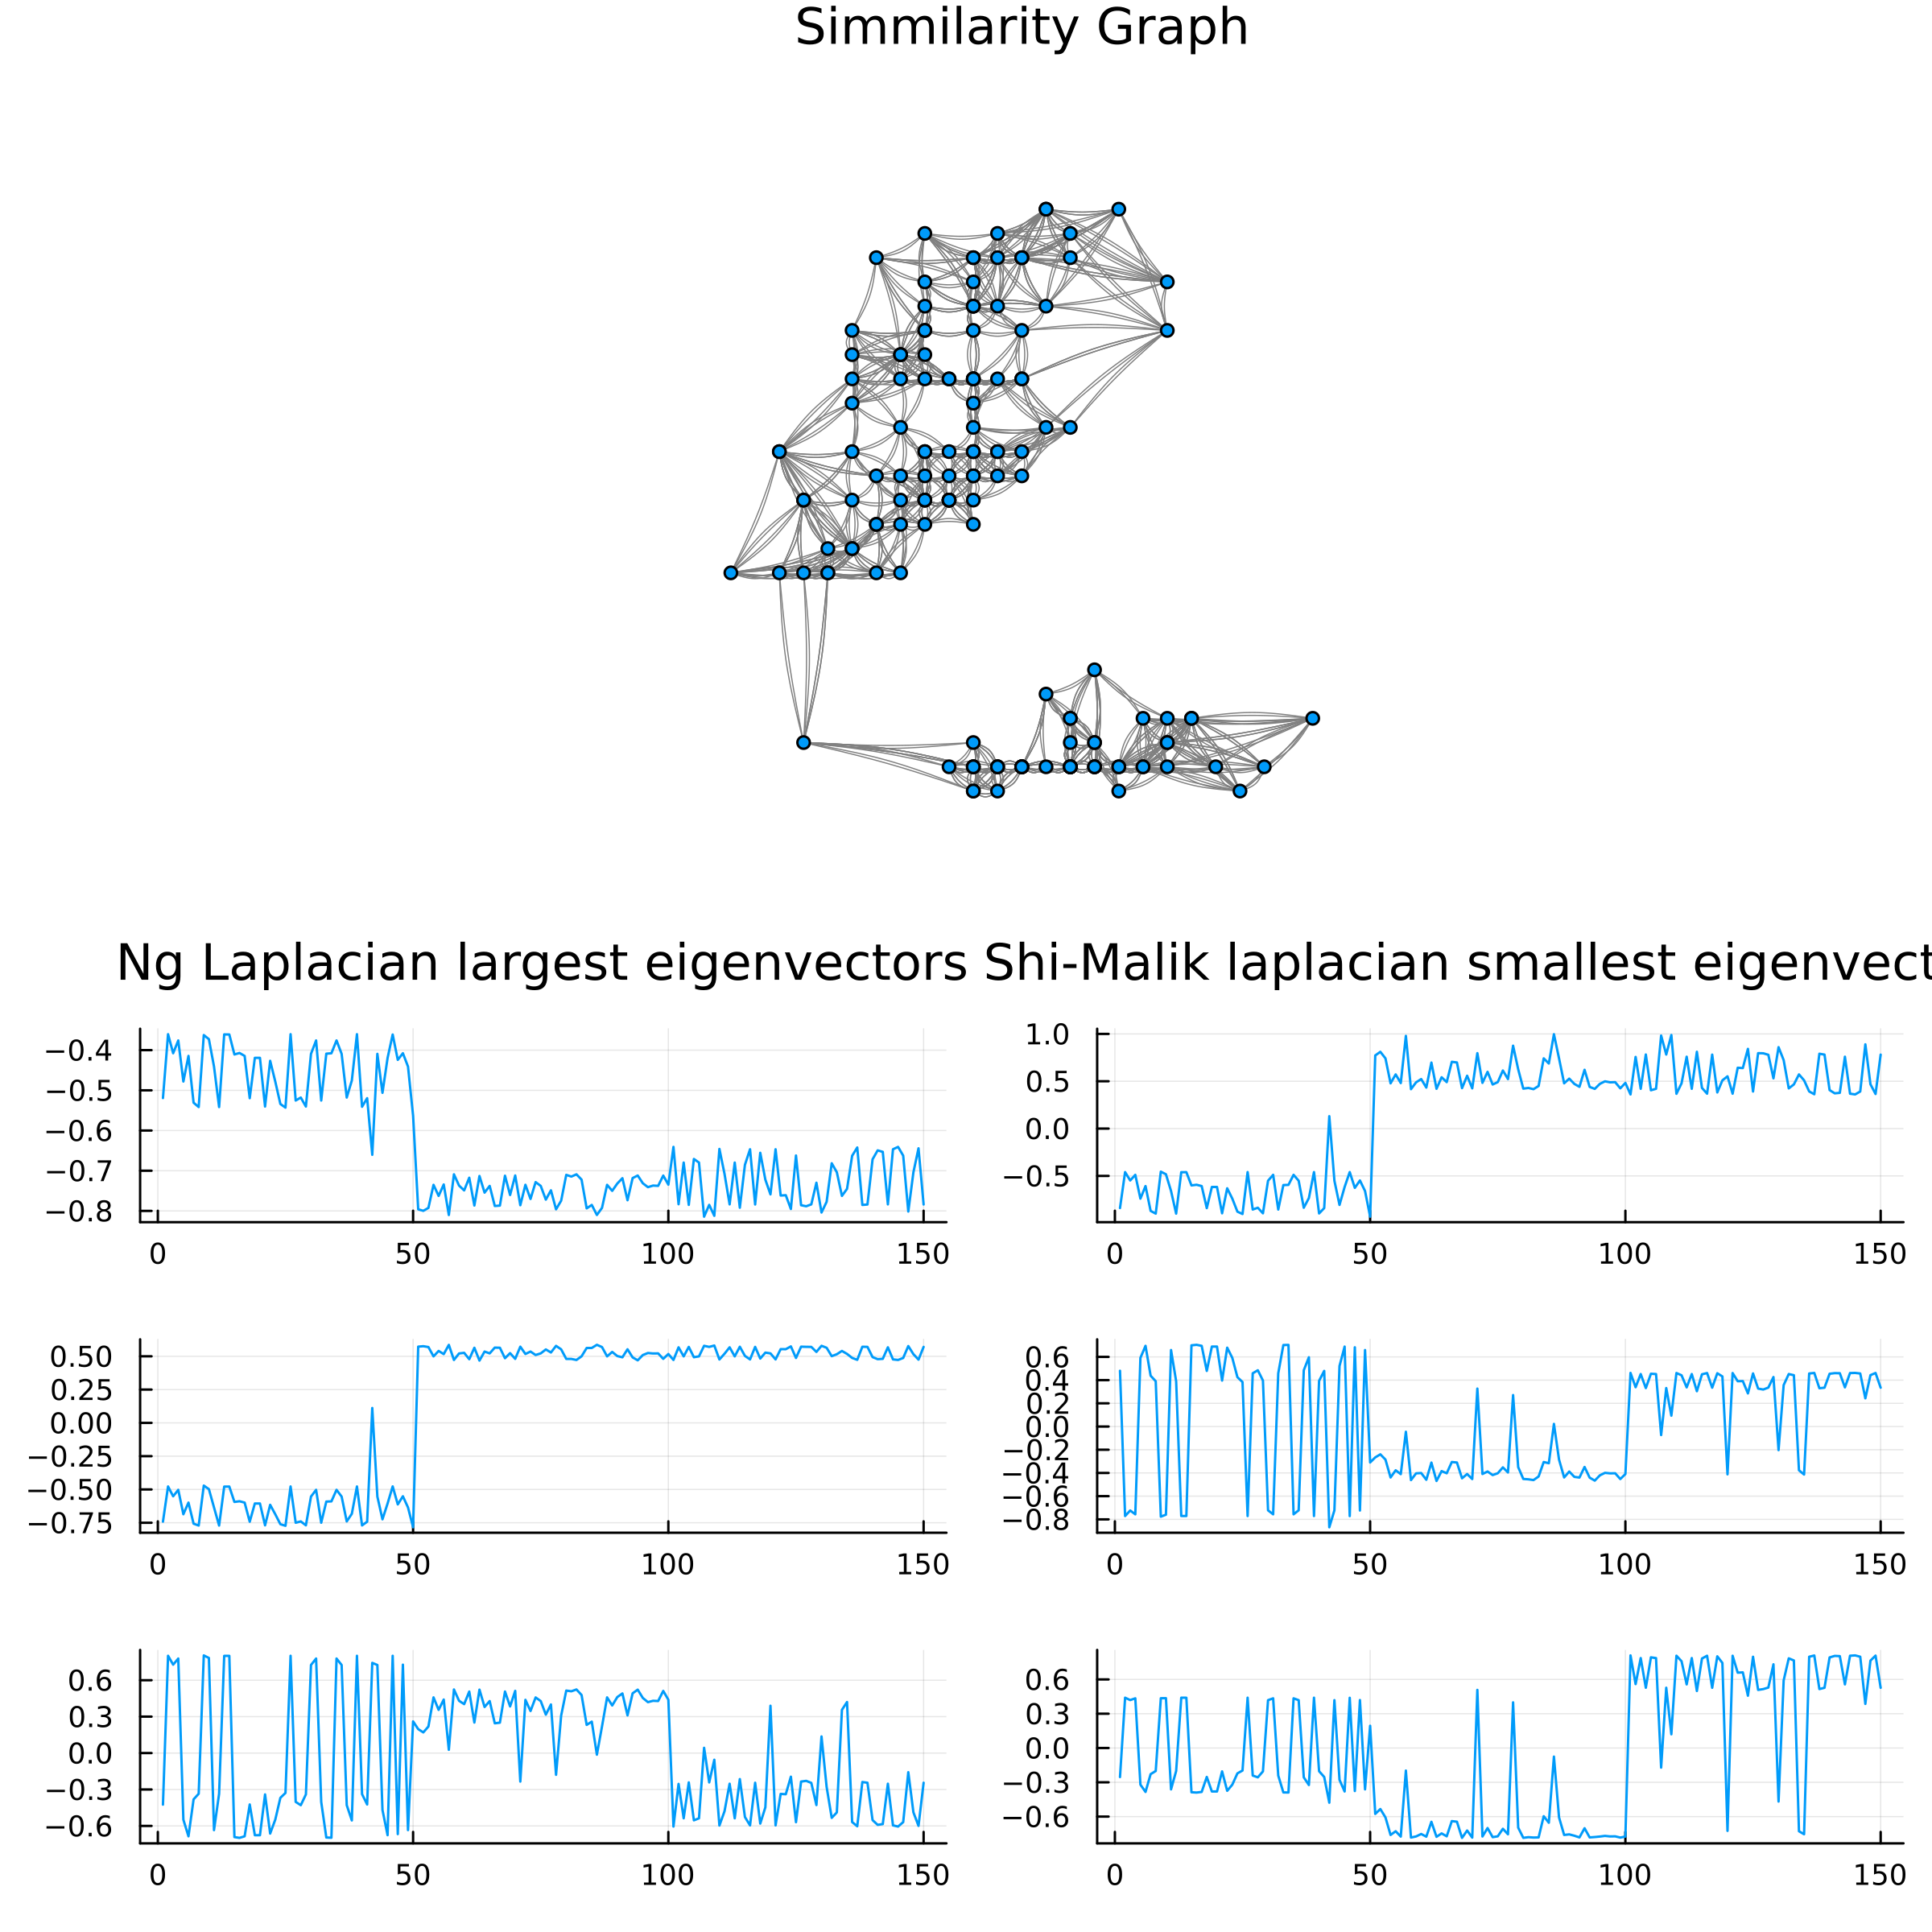

In [2]:
using RDatasets
using SpectralClustering
using Distances
using GraphRecipes

function weight(i::Integer, neigh, v, m, l_scale)
    return exp.(-Distances.colwise(SqEuclidean(),m,v)./(l_scale[i].*l_scale[neigh]))
end
function local_scale_fun(v, m)
    return Distances.colwise(Euclidean(),m,v)
end
d = dataset("datasets", "iris")
d = Matrix(d[:,[2,4]])'
knnconfig = KNNNeighborhood(d,10)
l_scale = local_scale(knnconfig, local_scale_fun, d  ) .+ eps()
weight_oracle = (i,neigh,v,m)->weight(i,neigh,v,m,l_scale)
G = create(knnconfig,weight_oracle,d);
ng_vec = embedding(NgLaplacian(3), G)
sm_vec = embedding(ShiMalikLaplacian(3),G);

using Plots
 
fig1 = Plots.plot(ng_vec[:,1:3], layout = (@layout grid(3,1)), legend=false)
title!(fig1.subplots[1], "Ng Laplacian largest eigenvectors")
fig2 = Plots.plot(sm_vec[:,1:3], layout = (@layout grid(3,1)), legend=false) 
title!(fig2.subplots[1], "Shi-Malik laplacian smallest eigenvectors")
plt = graphplot(G, markersize=.1, func=(source;kw...)->fixed_layout(d, source),
    nodeshape=:circle, curvature=0.005, edgecolor=:grey, edgewidth = (s, d, w) -> 0.5)
title!(plt, "Simmilarity Graph")
Plots.plot(plt, fig1,fig2,   layout=(@layout [a; grid(1,2)]), size=(800,800)  )

## Segmentation Given Partial Grouping Constraints
If partial information of the clustering is available,  in [Segmentation Given Partial Grouping Constraints](#yu2004segmentation) the authors showed that it is possible to incorporate that information to the optimization problem that spectral clustering algorithms solve.

Let $X \in R^{N \times K}$ a partition matrix where $X=\left[ X_1,...,X_K \right]$ and $X(i,l) = 1$ if $i \in V_l$ and 0 otherwise. Given that every $X_t$ is a binary indicator for partition $V_t$ and since envery pattern is asigned to one partition: $X \mathbf{1}_K = \mathbf{1}_N$.

Let $C=\left\{ c_1, c_2, ...,c_n \right\}$ be the partial information of the clustering. $c_i$ is a set of the patterns belonging to the same cluster. Each set produces |c_i| - 1 constraints. Each contraint  can be represented by an $N \times 1$ vector $U_k$  with only two non zero elements $U_k(i) = 1$ and $U_k(j)=-1$ if $i,j \in c_k$. Let $U$ be the matrix forme by every contraint vector located in the columns. Then the constraints satisfy $U^T X = 0$.

The constrained clustering problem for the normalized cuts criterion is the following:
$$
\begin{array}{cc}
  \max & \frac{1}{K} \sum\limits_{l=1}^K \dfrac{X_l^T W X_l}{X_l^T D X_l} \\
  s.t. & X \in \left\{ 0, 1\right\}^{N \times K}, \\
       & X\mathbf{1}_K  =\mathbf{1}_N, \\
       & U^T X = \mathbf{0}
\end{array}
$$
where $D=\mbox{diag}(W \mathbf{1}_N)$.


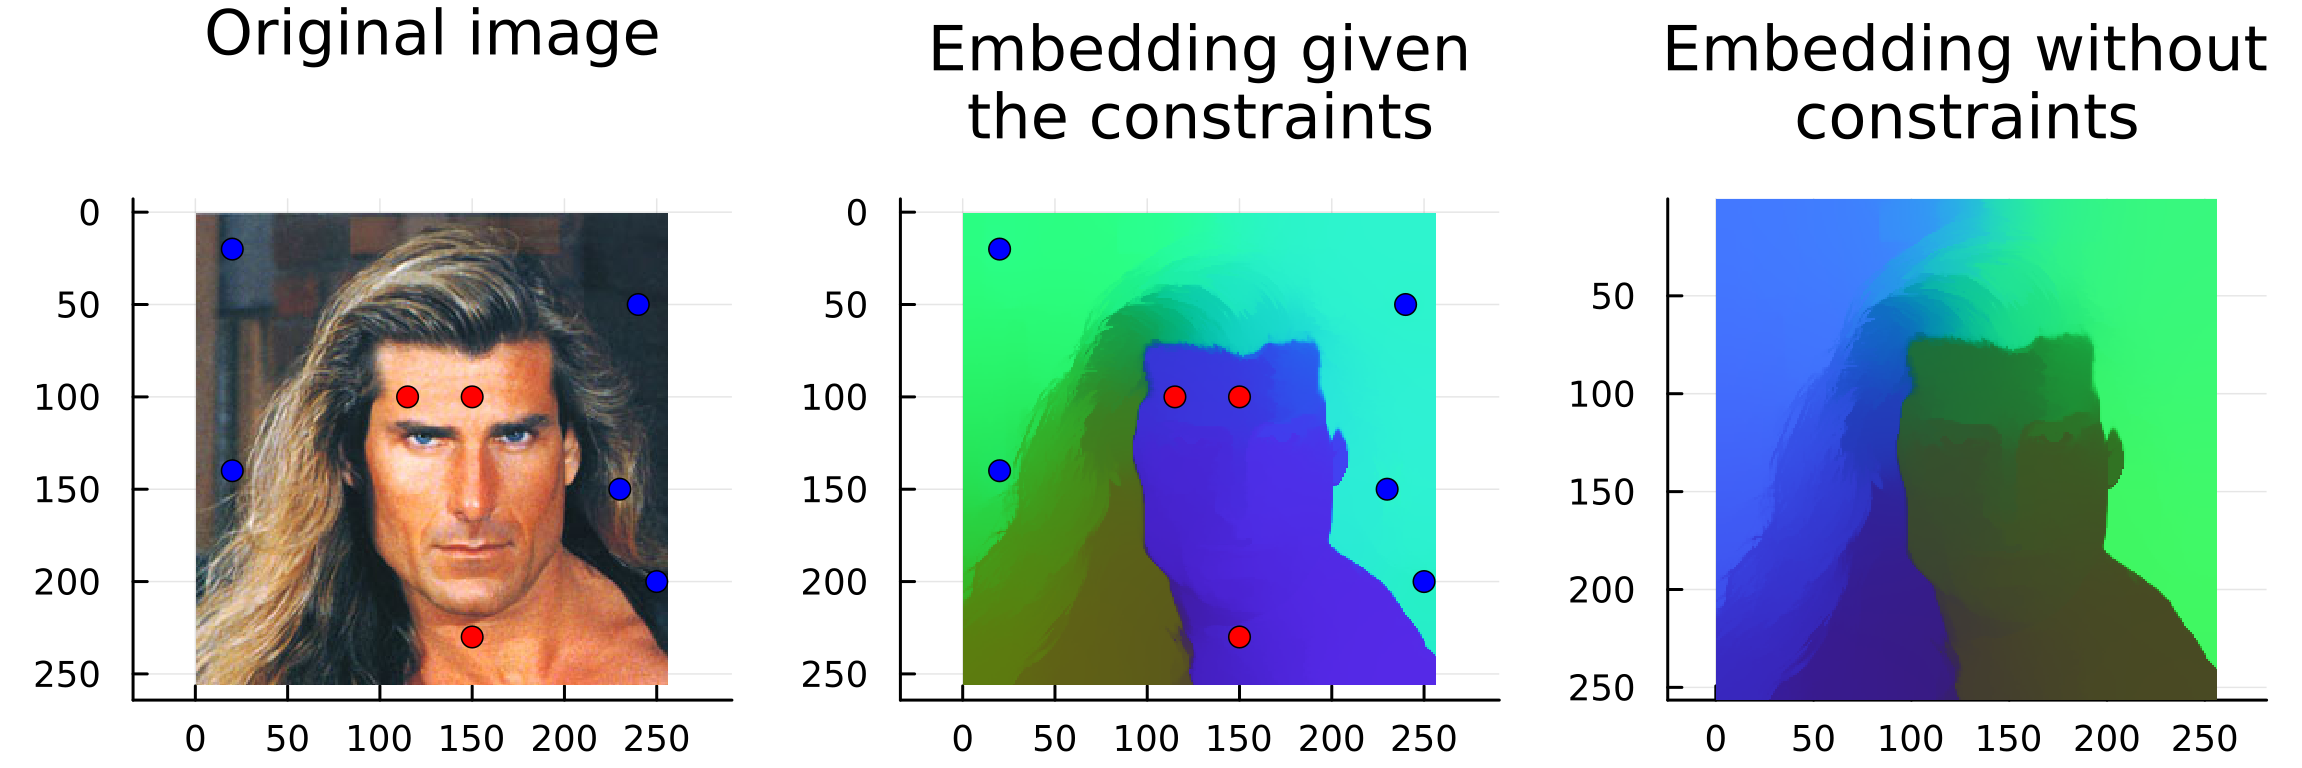

In [3]:
using TestImages, Images, Plots, SpectralClustering, Distances, LinearAlgebra, Statistics
function weight(i::Integer,j::Vector{<:Integer},pixel_i, neighbors_data)
    dist_sim =  exp.(-Distances.colwise(SqEuclidean(), pixel_i[1:2],neighbors_data[1:2,:])./(2*5^2))
    col_sim =  exp.(-Distances.colwise(SqEuclidean(), pixel_i[3:5],neighbors_data[3:5,:])./(2*0.05^2))
    return dist_sim.*col_sim
end
img = testimage("fabio_color_256");
nconfig = PixelNeighborhood(3);
G = create(Float64, nconfig, weight, img);
ng_vec = embedding(NgLaplacian(3), G);
fabio_pixels = ([100;100;230], [115;150;150])
back_pixels = ([140;200;50;20;150], [20;250;240;20;230])
fabio_linear_ind = LinearIndices(size(img))[[CartesianIndex(i,j) for (i,j) in zip(fabio_pixels...)]]
back_linear_ind = LinearIndices(size(img))[[CartesianIndex(i,j) for (i,j) in zip(back_pixels...)]];
constraints = Vector{Integer}[fabio_linear_ind, back_linear_ind ];


cg_vec = embedding(PartialGroupingConstraints(3, smooth=false, normalize=true), G, constraints)
cg_vec = cg_vec[:, 1:3]
ng_vec = ng_vec[:, 1:3]
img_ng = reshape(colorview(RGB, adjust_histogram(ng_vec, LinearStretching())'), size(img)) 
img_cg = reshape(colorview(RGB, adjust_histogram(cg_vec, LinearStretching())'), size(img))



using Measures
plt1 = Plots.plot(img, title="Original image", legend=false,top_margin=10.0mm); 
Plots.scatter!(plt1,fabio_pixels[2], fabio_pixels[1], c=:red, legend=false);
Plots.scatter!(plt1,back_pixels[2], back_pixels[1], c=:blue, legend=false);


plt2 = Plots.plot(img_cg, title="Embedding given\nthe constraints",top_margin=10.0mm, legend=false); 
Plots.scatter!(plt2, fabio_pixels[2], fabio_pixels[1],c=:red, legend=false);
Plots.scatter!(plt2, back_pixels[2], back_pixels[1], c=:blue, legend=false);

plt3 = Plots.plot(img_ng, title="Embedding without\nconstraints",top_margin=10.0mm);

Plots.plot(plt1, plt2,plt3,   layout =( @layout grid(1,3)), size=(size(img,1)*3,size(img,2))  )

## Negative weights
In the model proposed by [ref](#yu2001understanding) there are two non-negative weight matrices, $A$ and $R$. The matrix $A$ encodes the pairwise attraction, whereas, the matrix $R$ encodes the repulsion information. "The attraction measures the degree of association by feature similarity, the repulsion measures the segregation by feature dissimilarity".
The idea is  "having tight attraction within clusters and loose attraction between clusters at the same ime, strong repulsion between clusters and weak repulsion within clusters at the same time".

Let
$$\begin{array}{cc}
  W_{eq} &= A - R + D_R \\
   D_{eq} &= D_A + D_R
\end{array}$$
where $D_R = \text{diag}(R \mathbf{1})$ and $D_A = \text{diag}(A \mathbf{1})$ and

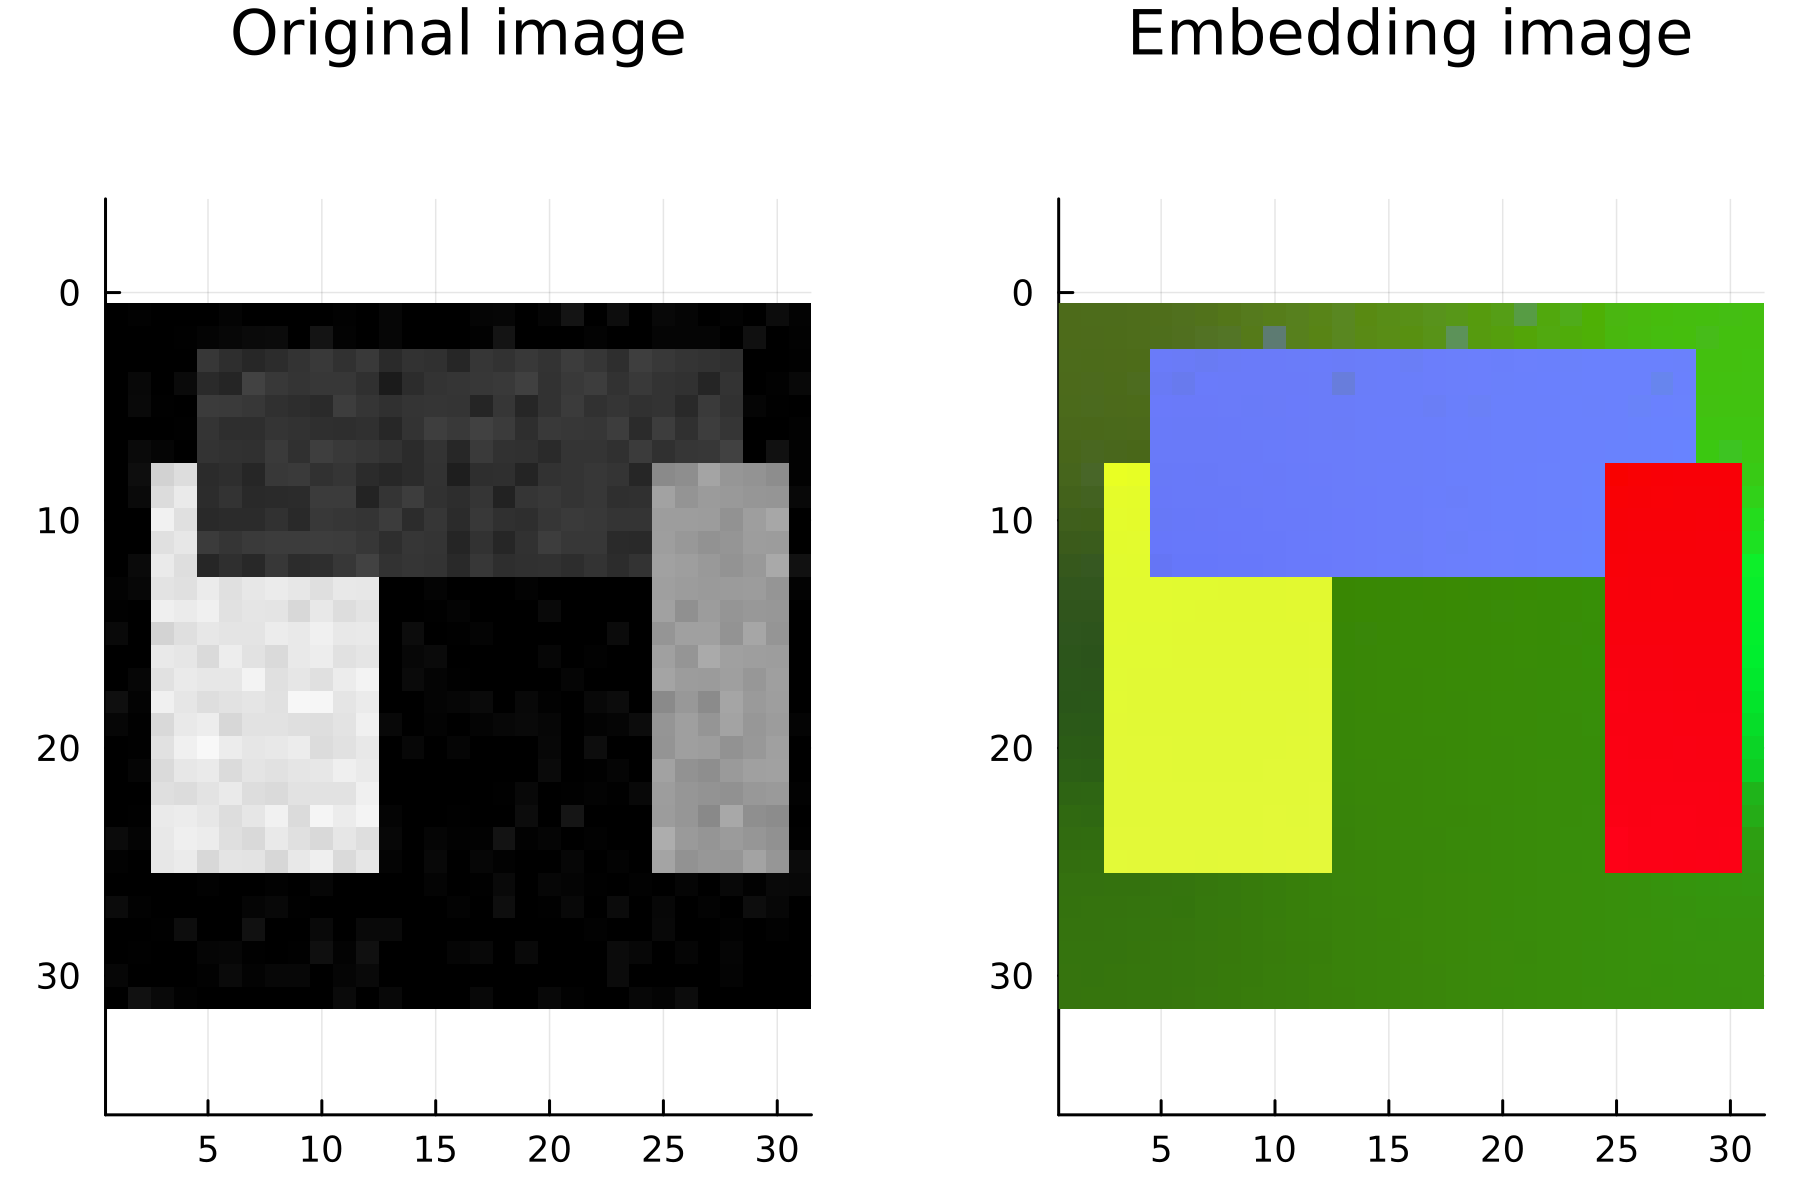

In [4]:
using Distributions, Distances, SpectralClustering, Images, Plots, Measures
function popout_weight(i::Integer, ineigh, vi, vneigh)
    intensity_dist = Distances.colwise(Euclidean(), vi[3:end], vneigh[3:end, :])
    xy_dist = Distances.colwise(Euclidean(), vi[1:2], vneigh[1:2, :])
    a = 5
    b = 0.05
    return (pdf.(Normal(0, a*15), xy_dist) - pdf.(Normal(0, a), xy_dist)) .*
           (pdf.(Normal(0, b*100), intensity_dist) - pdf.(Normal(0, b), intensity_dist))
end
function attraction(i::Integer, ineigh, vi, vneigh)
    diff = popout_weight(i, ineigh, vi, vneigh)
    diff[diff.<0] .= 0
    return diff
end
function repulsion(i::Integer, ineigh, vi, vneigh)
    diff = popout_weight(i, ineigh, vi, vneigh)
    diff[diff.>0] .= 0
    return abs.(diff)
end
img = zeros(31,31)
img[8:25, 3:12] .= 0.9
img[3:12, 5:28] .= 0.2
img[8:25, 25:30] .= 0.6
img = Gray.(img + randn(31, 31)*0.03)

labels = zeros(Integer, 31, 31)
labels[8:25, 3:12] .= 1
labels[3:12, 5:28] .= 2
labels[8:25, 25:30] .= 3

nconfig = PixelNeighborhood(4)
graph_attraction = create(nconfig, attraction, img);
graph_repulsion = create(nconfig, repulsion, img);

emb_config = YuShiPopout(3,  false)
emb = embedding(emb_config, graph_attraction, graph_repulsion)

embedding_image = reshape(colorview(RGB, hcat([adjust_histogram(emb[:,i], LinearStretching()) for i=1:3]...)'), (31,31))

plt1 = Plots.plot(img, title="Original image", legend=false,top_margin=10.0mm); 
plt2 = Plots.plot(embedding_image, title="Embedding image", legend=false, left_margin=10.0mm, top_margin=10.0mm); 
Plots.plot(plt1, plt2, layout =( @layout grid(1,2)))

# References

using DocUtils
display("text/html",bibliography(["ng2002spectral","shi2000normalized","yu2001understanding"]))